## Make a 3D disk

In [1]:
import sys
import os
import math
import galsim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation
from IPython.display import HTML

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

%matplotlib inline

In [2]:
def make_2d_disk():
    '''Simple disk with galsim'''
    inc = galsim.Angle(30,unit=galsim.degrees)
    gal = galsim.InclinedExponential(inc,scale_radius=2,flux=1e6)
    gal = gal.shear(g1=0.01, g2=0.01)
    psf = galsim.Moffat(beta=5, flux=1., half_light_radius=0.18)
    gal = galsim.Convolve([gal, psf])
    image = gal.drawImage(image=galsim.Image(150,150),scale=0.1)
    return image

Lets first do simplest form of Gaussian in the third dimension, assuming H$\alpha$, here there is no rotation ...

In [3]:
def add_third_gaussian1(redshift=0.0):
    
    center_lambda = (1+redshift)*6564 ## assuming H_alpha line here
    R = 1000.0 ## spectral resolution fixed for now
    range_lambda = 600 #Angstrom for now
    delta_lambda = center_lambda/R
    wavelength = np.linspace(center_lambda-range_lambda/2,center_lambda+range_lambda/2,range_lambda/delta_lambda)
    
    
    f = gaussian(wavelength,center_lambda,50)
    boz = []
    for w in range(len(wavelength)):
        random_seed = 20
        rng = galsim.BaseDeviate(random_seed+1)
        image = make_2d_disk()
        image.addNoise(galsim.PoissonNoise(rng,sky_level=0.1))
        im = image.array
        boz.append(f[w]*im)
    b = np.dstack(boz)
    return b/np.max(b)

b = add_third_gaussian1()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


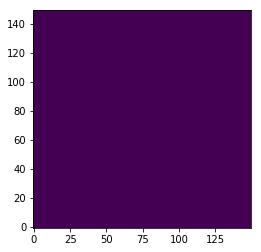

In [4]:
fig, ax = plt.subplots()

def animate(i):
    cf = ax.imshow(b[:,:,i],origin='lower',vmax=0.1)
    return cf

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(b[0,0]))
HTML(ani.to_jshtml())

Now adding rotation by changing the center of the gaussian 

In [5]:
def add_third_gaussian(redshift=0.0,v_asymp=200,r_turn=2,velocity_disp=10,inclination = 80):
    
    center_lambda = (1+redshift)*6563.8 ## assuming H_alpha line here
    R = 5000.0 ## spectral resolution fixed for now
    range_lambda = 200 #Angstrom for now
    delta_lambda = center_lambda/R
    wavelength = np.linspace(center_lambda-range_lambda/2,center_lambda+range_lambda/2,range_lambda/delta_lambda)
    inc = galsim.Angle(inclination,unit=galsim.degrees)
    gal = galsim.InclinedExponential(inc,scale_radius=1,flux=1e6)
    random_seed = 20
    rng = galsim.BaseDeviate(random_seed+1)    
    psf = galsim.Moffat(beta=5, flux=1., half_light_radius=0.18)
    gal = galsim.Convolve([gal, psf])
    image = gal.drawImage(image=galsim.Image(200,200),scale=0.06)
    image.addNoise(galsim.PoissonNoise(rng,sky_level=0.1))
    im = image.array
    
    xsize,ysize = np.shape(im)[0],np.shape(im)[0]
    boz = np.zeros((np.shape(im)[0],np.shape(im)[0],len(wavelength)))
    for i in range(xsize):
        for j in range(ysize):        
            r = np.sqrt((i-xsize/2.0)**2+((j-ysize/2)/np.cos(inc))**2.0) # double check later
            v = (2.0/np.pi)*v_asymp*np.arctan(r/r_turn)

            if j<xsize/2:
                phi = galsim.Angle(180.0*np.arctan((i-ysize/2)/(j-xsize/2.0))/np.pi,unit=galsim.degrees)
                mu = center_lambda+center_lambda*v*np.sin(inc)*np.cos(phi)/(3.0*10.0**5)
            elif j>xsize/2:
                phi = galsim.Angle(180.0*np.arctan((i-ysize/2)/(j-xsize/2.0))/np.pi,unit=galsim.degrees)
                mu = center_lambda-center_lambda*v*np.sin(inc)*np.cos(phi)/(3.0*10.0**5)
            else:
                mu = center_lambda
                
            f = gaussian(wavelength,mu,velocity_disp)
            for w in range(len(wavelength)):
                boz[i,j,w] = (f[w]*im[i,j])
        
    return wavelength,boz

w,b = add_third_gaussian()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


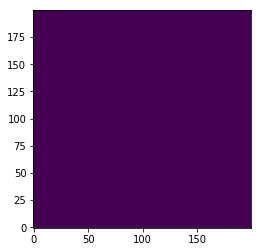

In [10]:
fig, ax = plt.subplots()
def animate(i):
    cf = ax.imshow(b[:,:,i],origin='lower',vmax=10.0)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(b[0,0]))
HTML(ani.to_jshtml())

In [7]:
def slit_spectra(w,b):
    this,that = np.zeros_like(b[:,:,0]),np.zeros_like(b[:,:,0])
    for i in range(len(b[:,0,0])):
        for j in range(len(b[0,:,0])):
            
            this[i,j]=np.argmax(b[i,j,:])
    u = (this==0)| (this==151)
    this[u]=np.nan
    for i in range(len(b[:,0,0])):
        for j in range(len(b[0,:,0])):
            if np.isfinite(this[i,j]):
                that[i,j]=3.0*10.0**5*(w[np.int(this[i,j])]-6563.8)/6563.8
    that[u]=np.nan
    return that

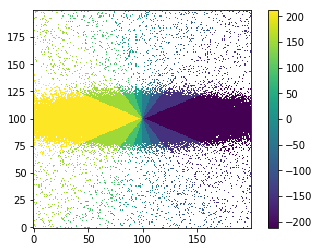

In [8]:
y = slit_spectra(w,b)
plt.imshow(y,origin='lower')
plt.colorbar()

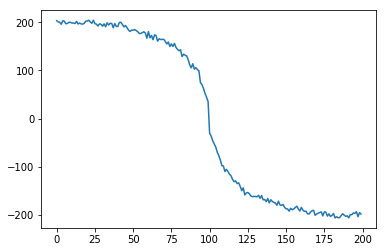

In [9]:
z = np.nanmean(y,axis=0)
plt.plot(z)